In [ ]:
!cp -av /content/drive/MyDrive/spa-eng.zip /content/

'/content/drive/MyDrive/spa-eng.zip' -> '/content/spa-eng.zip'


In [ ]:
!unzip /content/spa-eng.zip

Archive:  /content/spa-eng.zip
  inflating: _about.txt              
  inflating: spa.txt                 


Import Library

In [ ]:
import string
import re
from numpy import array, argmax, random, take
import pandas as pd
import numpy
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, RepeatVector,Dropout
from keras.preprocessing.text import Tokenizer
from keras.callbacks import ModelCheckpoint
from keras_preprocessing.sequence import pad_sequences
from keras.models import load_model
from keras import optimizers
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option('display.max_colwidth', 200)

Read Data

In [ ]:
# function to read raw text file
def read_text(filename):
    # open the file
    file = open(filename, mode='rt', encoding='utf-8')
    # read all text
    text = file.read()
    file.close()
    return text

In [ ]:
# split a text into sentences
def to_lines(text):
    sents = text.strip().split('\n')
    sents = [i.split('\t') for i in sents]
    return sents

In [ ]:
data = read_text("spa.txt")
spa_eng = to_lines(data)
spa_eng = array(spa_eng)

English:

In [ ]:
print(spa_eng[:,0])

['Go.' 'Go.' 'Go.' ...
 'If you want to sound like a native speaker, you must be willing to practice saying the same sentence over and over in the same way that banjo players practice the same phrase over and over until they can play it correctly and at the desired tempo.'
 'It may be impossible to get a completely error-free corpus due to the nature of this kind of collaborative effort. However, if we encourage members to contribute sentences in their own languages rather than experiment in languages they are learning, we might be able to minimize errors.'
 "One day, I woke up to find that God had put hair on my face. I shaved it off. The next day, I found that God had put it back on my face, so I shaved it off again. On the third day, when I found that God had put hair back on my face again, I decided to let God have his way. That's why I have a beard."]


Spanish:

In [ ]:
print(spa_eng[:,1])

['Ve.' 'Vete.' 'Vaya.' ...
 'Si quieres sonar como un hablante nativo, debes estar dispuesto a practicar diciendo la misma frase una y otra vez de la misma manera en que un músico de banjo practica el mismo fraseo una y otra vez hasta que lo puedan tocar correctamente y en el tiempo esperado.'
 'Puede que sea imposible obtener un corpus completamente libre de errores debido a la naturaleza de este tipo de esfuerzo de colaboración. Sin embargo, si animamos a los miembros a contribuir frases en sus propios idiomas en lugar de experimentar con los idiomas que están aprendiendo, podríamos ser capaces de minimizar los errores.'
 'Un día, me desperté y vi que Dios me había puesto pelo en la cara. Me lo afeité. Al día siguiente, vi que Dios me lo había vuelto a poner en la cara, así que me lo afeité otra vez. Al tercer día, cuando vi que Dios me había puesto pelo en la cara de nuevo, decidí que Dios se saliera con la suya. Por eso tengo barba.']


Text Preprocessing:

In [ ]:
# Remove punctuation
spa_eng[:,0] = [s.translate(str.maketrans('', '', string.punctuation)) for s in spa_eng[:,0]]
spa_eng[:,1] = [s.translate(str.maketrans('', '', string.punctuation)) for s in spa_eng[:,1]]

In [ ]:
spa_eng[:,0]=spa_eng[:,0]
spa_eng[:,1]=spa_eng[:,1]

In [ ]:
print(spa_eng[0,2])

CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #4986655 (cueyayotl)


In [ ]:
spa_eng=numpy.delete(spa_eng,2,axis=1)

In [ ]:
spa_eng

array([['Go', 'Ve'],
       ['Go', 'Vete'],
       ['Go', 'Vaya'],
       ...,
       ['If you want to sound like a native speaker you must be willing to practice saying the same sentence over and over in the same way that banjo players practice the same phrase over and over until they can play it correctly and at the desired tempo',
        'Si quieres sonar como un hablante nativo debes estar dispuesto a practicar diciendo la misma frase una y otra vez de la misma manera en que un músico de banjo practica el mismo fraseo una y otra vez hasta que lo puedan tocar correctamente y en el tiempo esperado'],
       ['It may be impossible to get a completely errorfree corpus due to the nature of this kind of collaborative effort However if we encourage members to contribute sentences in their own languages rather than experiment in languages they are learning we might be able to minimize errors',
        'Puede que sea imposible obtener un corpus completamente libre de errores debido a la na

In [ ]:
# convert to lowercase
for i in range(len(spa_eng)):
    spa_eng[i,0] = spa_eng[i,0].lower()
    
    spa_eng[i,1] = spa_eng[i,1].lower()

In [ ]:
spa_eng

array([['go', 've'],
       ['go', 'vete'],
       ['go', 'vaya'],
       ...,
       ['if you want to sound like a native speaker you must be willing to practice saying the same sentence over and over in the same way that banjo players practice the same phrase over and over until they can play it correctly and at the desired tempo',
        'si quieres sonar como un hablante nativo debes estar dispuesto a practicar diciendo la misma frase una y otra vez de la misma manera en que un músico de banjo practica el mismo fraseo una y otra vez hasta que lo puedan tocar correctamente y en el tiempo esperado'],
       ['it may be impossible to get a completely errorfree corpus due to the nature of this kind of collaborative effort however if we encourage members to contribute sentences in their own languages rather than experiment in languages they are learning we might be able to minimize errors',
        'puede que sea imposible obtener un corpus completamente libre de errores debido a la na

Text to Sequence conversion:

In [ ]:
# empty lists
eng_l = []
spa_l = []

# populate the lists with sentence lengths
for i in spa_eng[:,0]:
    eng_l.append(len(i.split()))

for i in spa_eng[:,1]:
    spa_l.append(len(i.split()))

In [ ]:
length_df = pd.DataFrame({'eng':eng_l, 'spa':spa_l})

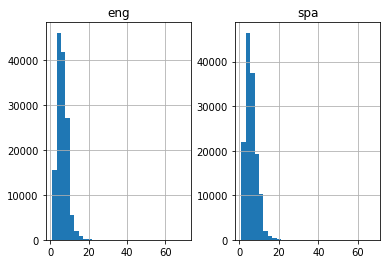

In [ ]:
length_df.hist(bins = 30)
plt.show()

The maximum length of the Spanish sentences is 20 and that of the English phrases is 20.

In [ ]:
# function to build a tokenizer
def tokenization(lines):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

In [ ]:
# prepare english tokenizer
eng_tokenizer = tokenization(spa_eng[:, 0])
eng_vocab_size = len(eng_tokenizer.word_index) + 1

eng_length = 20
print('English Vocabulary Size: %d' % eng_vocab_size)

English Vocabulary Size: 14440


In [ ]:
# prepare Deutch tokenizer
spa_tokenizer = tokenization(spa_eng[:, 1])
spa_vocab_size = len(spa_tokenizer.word_index) + 1

spa_length = 20
print('Spanish Vocabulary Size: %d' % spa_vocab_size)

Spanish Vocabulary Size: 29031


In [ ]:
# encode and pad sequences
def encode_sequences(tokenizer, length, lines):
    # integer encode sequences
    seq = tokenizer.texts_to_sequences(lines)
    # pad sequences with 0 values
    seq = pad_sequences(seq, maxlen=length, padding='post')
    return seq

Model Building:

In [ ]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(spa_eng, test_size=0.2, random_state = 12)

In [ ]:
# prepare training data
trainX = encode_sequences(spa_tokenizer, spa_length, train[:, 1])
trainY = encode_sequences(eng_tokenizer, eng_length, train[:, 0])

In [ ]:
# prepare validation data
testX = encode_sequences(spa_tokenizer, spa_length, test[:, 1])
testY = encode_sequences(eng_tokenizer, eng_length, test[:, 0])

In [ ]:
# build NMT model
def build_model(in_vocab, out_vocab, in_timesteps, out_timesteps, units):
    model = Sequential()
    model.add(Embedding(in_vocab, units, input_length=in_timesteps, mask_zero=True))
    model.add(LSTM(units))
    model.add(Dropout(0.5))
    model.add(RepeatVector(out_timesteps))
    model.add(LSTM(units, return_sequences=True))
    model.add(Dropout(0.25))
    model.add(Dense(out_vocab, activation='softmax'))
    return model

In [ ]:
model = build_model(spa_vocab_size, eng_vocab_size, spa_length, eng_length, 512)
adam = optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=adam, loss='sparse_categorical_crossentropy')

In [ ]:
filename = 'model.h1.7_nov_22_2'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

history = model.fit(trainX, trainY.reshape(trainY.shape[0], trainY.shape[1], 1), 
          epochs=30, batch_size=32, 
          validation_split = 0.2,
          callbacks=[checkpoint], verbose=1)

Epoch 1/30
2780/2781 [============================>.] - ETA: 0s - loss: 2.0720
Epoch 1: val_loss improved from inf to 1.86511, saving model to model.h1.7_nov_22_2


2781/2781 [==============================] - 107s 36ms/step - loss: 2.0720 - val_loss: 1.8651
Epoch 2/30
2781/2781 [==============================] - ETA: 0s - loss: 1.7602
Epoch 2: val_loss improved from 1.86511 to 1.60212, saving model to model.h1.7_nov_22_2


2781/2781 [==============================] - 100s 36ms/step - loss: 1.7602 - val_loss: 1.6021
Epoch 3/30
2779/2781 [============================>.] - ETA: 0s - loss: 1.5149
Epoch 3: val_loss improved from 1.60212 to 1.39623, saving model to model.h1.7_nov_22_2


2781/2781 [==============================] - 100s 36ms/step - loss: 1.5149 - val_loss: 1.3962
Epoch 4/30
2779/2781 [============================>.] - ETA: 0s - loss: 1.3264
Epoch 4: val_loss improved from 1.39623 to 1.26619, saving model to model.h1.7_nov_22_2


2781/2781 [==============================] - 101s 36ms/step - loss: 1.3263 - val_loss: 1.2662
Epoch 5/30
2781/2781 [==============================] - ETA: 0s - loss: 1.1886
Epoch 5: val_loss improved from 1.26619 to 1.17901, saving model to model.h1.7_nov_22_2


2781/2781 [==============================] - 100s 36ms/step - loss: 1.1886 - val_loss: 1.1790
Epoch 6/30
2781/2781 [==============================] - ETA: 0s - loss: 1.0838
Epoch 6: val_loss improved from 1.17901 to 1.12328, saving model to model.h1.7_nov_22_2


2781/2781 [==============================] - 100s 36ms/step - loss: 1.0838 - val_loss: 1.1233
Epoch 7/30
2781/2781 [==============================] - ETA: 0s - loss: 1.0035
Epoch 7: val_loss improved from 1.12328 to 1.08245, saving model to model.h1.7_nov_22_2


2781/2781 [==============================] - 100s 36ms/step - loss: 1.0035 - val_loss: 1.0824
Epoch 8/30
2781/2781 [==============================] - ETA: 0s - loss: 0.9414
Epoch 8: val_loss improved from 1.08245 to 1.05506, saving model to model.h1.7_nov_22_2


2781/2781 [==============================] - 100s 36ms/step - loss: 0.9414 - val_loss: 1.0551
Epoch 9/30
2779/2781 [============================>.] - ETA: 0s - loss: 0.8894
Epoch 9: val_loss improved from 1.05506 to 1.03781, saving model to model.h1.7_nov_22_2


2781/2781 [==============================] - 100s 36ms/step - loss: 0.8894 - val_loss: 1.0378
Epoch 10/30
2779/2781 [============================>.] - ETA: 0s - loss: 0.8468
Epoch 10: val_loss improved from 1.03781 to 1.02324, saving model to model.h1.7_nov_22_2


2781/2781 [==============================] - 100s 36ms/step - loss: 0.8468 - val_loss: 1.0232
Epoch 11/30
2781/2781 [==============================] - ETA: 0s - loss: 0.8075
Epoch 11: val_loss improved from 1.02324 to 1.01694, saving model to model.h1.7_nov_22_2


2781/2781 [==============================] - 100s 36ms/step - loss: 0.8075 - val_loss: 1.0169
Epoch 12/30
2781/2781 [==============================] - ETA: 0s - loss: 0.7777
Epoch 12: val_loss improved from 1.01694 to 1.01041, saving model to model.h1.7_nov_22_2


2781/2781 [==============================] - 100s 36ms/step - loss: 0.7777 - val_loss: 1.0104
Epoch 13/30
2781/2781 [==============================] - ETA: 0s - loss: 0.7516
Epoch 13: val_loss improved from 1.01041 to 1.00742, saving model to model.h1.7_nov_22_2


2781/2781 [==============================] - 104s 37ms/step - loss: 0.7516 - val_loss: 1.0074
Epoch 14/30
2781/2781 [==============================] - ETA: 0s - loss: 0.7264
Epoch 14: val_loss did not improve from 1.00742
2781/2781 [==============================] - 86s 31ms/step - loss: 0.7264 - val_loss: 1.0079
Epoch 15/30
2779/2781 [============================>.] - ETA: 0s - loss: 0.7057
Epoch 15: val_loss improved from 1.00742 to 1.00382, saving model to model.h1.7_nov_22_2


2781/2781 [==============================] - 99s 36ms/step - loss: 0.7058 - val_loss: 1.0038
Epoch 16/30
2781/2781 [==============================] - ETA: 0s - loss: 0.6864
Epoch 16: val_loss did not improve from 1.00382
2781/2781 [==============================] - 85s 31ms/step - loss: 0.6864 - val_loss: 1.0039
Epoch 17/30
2781/2781 [==============================] - ETA: 0s - loss: 0.6706
Epoch 17: val_loss did not improve from 1.00382
2781/2781 [==============================] - 86s 31ms/step - loss: 0.6706 - val_loss: 1.0049
Epoch 18/30
2781/2781 [==============================] - ETA: 0s - loss: 0.6538
Epoch 18: val_loss did not improve from 1.00382
2781/2781 [==============================] - 86s 31ms/step - loss: 0.6538 - val_loss: 1.0055
Epoch 19/30
2781/2781 [==============================] - ETA: 0s - loss: 0.6400
Epoch 19: val_loss did not improve from 1.00382
2781/2781 [==============================] - 86s 31ms/step - loss: 0.6400 - val_loss: 1.0094
Epoch 20/30
2779/2781 [

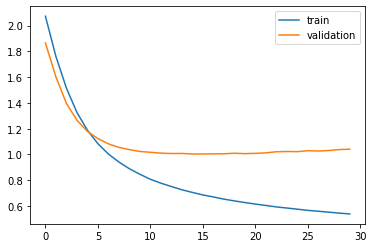

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','validation'])
plt.show()

In [ ]:
!cp -av /content/drive/MyDrive/model.h1.7_nov_22_2 /content/

'/content/drive/MyDrive/model.h1.7_nov_22_2' -> '/content/model.h1.7_nov_22_2'
'/content/drive/MyDrive/model.h1.7_nov_22_2/assets' -> '/content/model.h1.7_nov_22_2/assets'
'/content/drive/MyDrive/model.h1.7_nov_22_2/variables' -> '/content/model.h1.7_nov_22_2/variables'
'/content/drive/MyDrive/model.h1.7_nov_22_2/variables/variables.index' -> '/content/model.h1.7_nov_22_2/variables/variables.index'
'/content/drive/MyDrive/model.h1.7_nov_22_2/variables/variables.data-00000-of-00001' -> '/content/model.h1.7_nov_22_2/variables/variables.data-00000-of-00001'
'/content/drive/MyDrive/model.h1.7_nov_22_2/saved_model.pb' -> '/content/model.h1.7_nov_22_2/saved_model.pb'
'/content/drive/MyDrive/model.h1.7_nov_22_2/keras_metadata.pb' -> '/content/model.h1.7_nov_22_2/keras_metadata.pb'


In [ ]:
testX=testX[1000:]

In [ ]:
len(testX.reshape((testX.shape[0],testX.shape[1])))

4703

In [ ]:
model = load_model('model.h1.7_nov_22_2')
preds = model.predict(testX.reshape((testX.shape[0],testX.shape[1])),batch_size=2)

2352/2352 [==============================] - 161s 68ms/step


In [ ]:
def get_word(n, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == n:
            return word
    return None

In [ ]:
# convert predictions into text (English)
preds_text = []
for i in preds:
    temp = []
    for j in range(len(i)):
        t = get_word(i[j], eng_tokenizer)
        if j > 0:
            if (t == get_word(i[j-1], eng_tokenizer)) or (t == None):
                temp.append('')
            else:
                temp.append(t)
             
        else:
            if(t == None):
                temp.append('')
            else:
                temp.append(t)            
        
    preds_text.append(' '.join(temp))

In [ ]:


pred_df = pd.DataFrame({'actual' : test[:,0], 'predicted' : preds_text})

pd.set_option('display.max_colwidth', 200)

In [ ]:
pred_df.head(15)

In [ ]:
!pip install numba

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from numba import cuda 
device = cuda.get_current_device()
device.reset()